# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="Banana.app") #"/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
env.reset()

{'BananaBrain': <unityagents.brain.BrainInfo at 0x10bdf39e8>}

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [0.         1.         0.         0.         0.16895212 0.
 1.         0.         0.         0.20073597 1.         0.
 0.         0.         0.12865657 0.         1.         0.
 0.         0.14938059 1.         0.         0.         0.
 0.58185619 0.         1.         0.         0.         0.16089135
 0.         1.         0.         0.         0.31775284 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

In [ ]:
env.close()

In [5]:
# Neural Network Model Training Parameters
EPOCHS = 1
BATCH_SIZE = 64
TAU = 1e-3  # for soft update of target parameters
LR = 5e-4 # learning rate 
GAMMA = 0.99

from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, x, y, z):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y
        self.z = z


    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index], self.z[index]

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import OrderedDict, deque, namedtuple

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DQN(nn.Module):
    def __init__(self, num_state, num_actions, layer_size=[64, 64], seed=0):
        super(DQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.num_state = num_state
        self.num_actions = num_actions
        self.layer_size = layer_size
        
        self.model = nn.Sequential(OrderedDict([        
            ('fc1', nn.Linear(self.num_state, self.layer_size[0])),
            ('relu1', nn.ReLU()),
            ('fc2', nn.Linear(self.layer_size[0], self.layer_size[1])),
            ('relu2', nn.ReLU()),            
            ('output', nn.Linear(self.layer_size[1], self.num_actions)),
        ]))
    
    def forward(self, input_state):
        output = self.model.forward(input_state)
        return output        

In [7]:
print(DEVICE)

cpu


In [8]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, seed=0):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple(
            "Experience",
            field_names=["state", "action", "reward", "next_state", "done"]
        )
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self, sample_size):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=sample_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(DEVICE)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(DEVICE)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(DEVICE)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(DEVICE)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(DEVICE)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [9]:
import random

class Agent:
    def __init__(self, num_state, num_actions, brain_name, gamma):
        
        self.num_state = num_state
        self.num_actions = num_actions
        self.brain_name = brain_name
        self.gamma = gamma

        # Q-Networks
        self.qnetwork_local = DQN(self.num_state, self.num_actions).to(DEVICE)
        self.qnetwork_target = DQN(self.num_state, self.num_actions).to(DEVICE)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
    
    def act(self, current_state, eps):
        current_state = torch.from_numpy(current_state).float().unsqueeze(0).to(DEVICE)
        
        self.qnetwork_local.eval() # sets the network on evaluation mode        
        with torch.no_grad():
            action_values = self.qnetwork_local(current_state)
        
        self.qnetwork_local.train() # sets the network back to training mode

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return np.random.randint(self.num_actions)
    
    def simulate_step(self, env, action):        
        env_info = env.step(action)[self.brain_name] # send the action to the environment
        next_state = env_info.vector_observations[0] # get the next state
        reward = env_info.rewards[0] # get the reward
        done = env_info.local_done[0] # end of episode?        
        return next_state, reward, done
    
    def train_update_DQN(self, experience_tuples):
        states, actions, rewards, next_states, dones = experience_tuples
        
        # generate target values for training neural networks
        target = torch.zeros(dones.size())
        with torch.no_grad():
            target_network_output = self.qnetwork_target.forward(next_states)
        target_network_output = target_network_output.max(dim=1)[0]
        target_network_output = target_network_output.resize_(rewards.size())
        target = rewards + (self.gamma * target_network_output * (1-dones))
        
        index  = np.arange(len(states))
        
        for epoch in range(EPOCHS):
            running_loss = 0
            train_ds = MyDataset(states, target, actions)
            train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)

            for batch_idx, (X_batch, y_batch, action_batch) in enumerate(train_loader):                
                outputs = self.qnetwork_local.forward(X_batch)
                output = outputs.gather(1, action_batch)
                loss = F.mse_loss(output, y_batch)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                running_loss += loss.item()
                
        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        
        
        

In [ ]:
TRAIN_STEPS = 4
BUFFER_SIZE =  int(1e5) 
SAMPLE_SIZE = 64

def run_simulation(
    env, brain_name, 
    num_state, num_actions,
    seed=1234,
    num_episodes=2000, max_steps_per_episode=1000,
    eps_start=1.0, eps_end=0.02, eps_decay=0.995
):
    agent = Agent(num_state=num_state, num_actions=num_actions, brain_name=brain_name, gamma=GAMMA)
    
    scores = [] # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start # initialize epsilon
    
    num_total_steps = 0
    memory = ReplayBuffer(action_size, BUFFER_SIZE, seed)
    
    for i_episode in range(1, num_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        current_state = env_info.vector_observations[0]
        score = 0
        
        for t in range(max_steps_per_episode):
            action = agent.act(current_state, eps)
            next_state, reward, done = agent.simulate_step(env, action)
            memory.add(current_state, action, reward, next_state, done)
            num_total_steps += 1
            
            current_state = next_state
            score += reward
            
            if num_total_steps % TRAIN_STEPS == 0 and len(memory) > SAMPLE_SIZE:
                #print('training')
                samples = memory.sample(SAMPLE_SIZE)
                agent.train_update_DQN(samples)
            
            if done:
                break
        
        # task to perform at the end of each episode
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores
    

In [ ]:
result = run_simulation(env, brain_name, state_size, action_size)

In [ ]:
from matplotlib import pyplot as plt
plt.plot(result)

In [ ]:
len(result)

In [ ]:
import numpy as np

In [ ]:
np.savez('result.npz', result=result)

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [14]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (20,10)


In [15]:
res = np.load('result.npz')

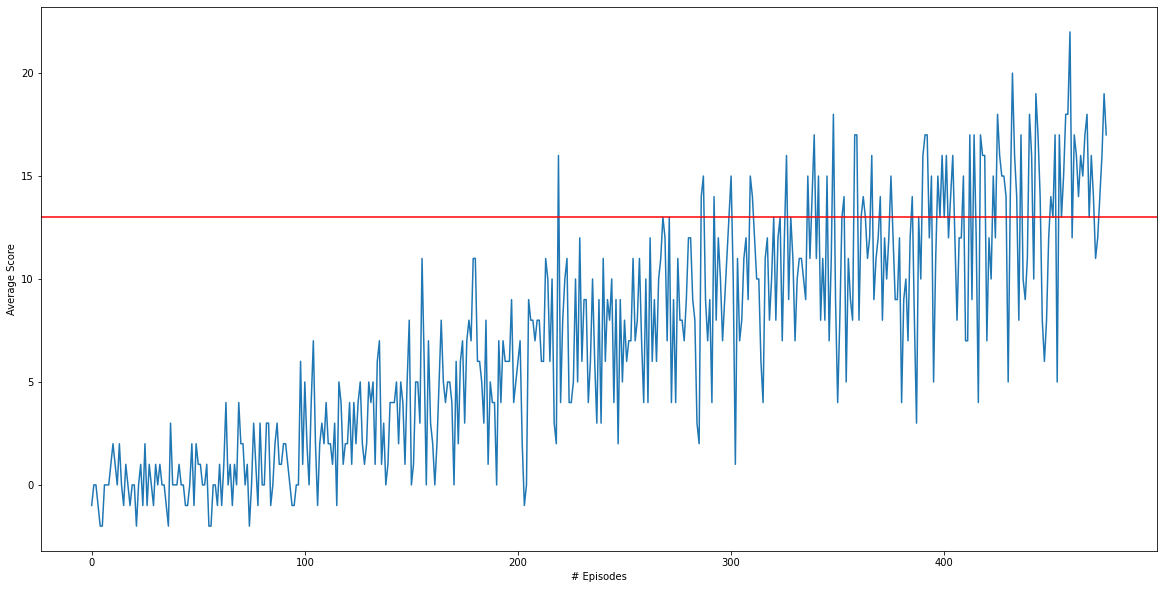

In [16]:
plt.plot(res['result'])
plt.xlabel('# Episodes')
plt.ylabel('Average Score')
plt.axhline(13, color='red')
plt.show()

In [10]:
def run_trained_model(env, brain_name, num_state, num_actions):
    agent = Agent(num_state=num_state, num_actions=num_actions, brain_name=brain_name, gamma=GAMMA)
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth', map_location={'cuda:0': 'cpu'}))

    env_info = env.reset(train_mode=False)[brain_name]
    current_state = env_info.vector_observations[0]
    while True:
        action = agent.act(current_state, eps=0.0)
        next_state, reward, done = agent.simulate_step(env, action)
            
        if done:
            break
        current_state = next_state    

In [11]:
run_trained_model(env, brain_name, state_size , action_size)
env.close()